In [64]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model

from sklearn.metrics import roc_curve, auc, RocCurveDisplay



# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

### Creating data generators:

In [59]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='input')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='input',
                                             shuffle=False)
     
     return train_gen, val_gen

# get the data generators
train_gen, val_gen = get_pcam_generators('C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/Jaar 3/Project AI MIA')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### Define autoencoder

In [95]:
def autoencoder(kernel_size=(3,3), pool_size=(2,2), first_filters=32, second_filters=16, third_filters=8):

     # build the model
     model = Sequential()

     # encoding
     model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size = pool_size)) 

     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))

     model.add(Conv2D(third_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))

     # decoding
     
     model.add(Conv2D(third_filters, kernel_size, activation='relu', padding='same'))
     model.add(UpSampling2D(pool_size))
    
     model.add(Conv2D(second_filters, kernel_size, activation='relu', padding='same'))
     model.add(UpSampling2D(pool_size))
     
     model.add(Conv2D(first_filters, kernel_size, activation='relu', padding='same'))
     model.add(UpSampling2D(pool_size))

     # reconstructing image
     model.add(Conv2D(3, kernel_size, activation='sigmoid', padding='same'))
    
     # compile the model
     model.compile(Adam(learning_rate=0.001), loss = 'mse', metrics=['accuracy'])

     return model

AE = autoencoder()

In [96]:
AE.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_94 (Conv2D)          (None, 48, 48, 16)        4624      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 24, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_95 (Conv2D)          (None, 24, 24, 8)         1160      
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 12, 12, 8)       

In [97]:
for layer in AE.layers:
    print(layer.output_shape)

(None, 96, 96, 32)
(None, 48, 48, 32)
(None, 48, 48, 16)
(None, 24, 24, 16)
(None, 24, 24, 8)
(None, 12, 12, 8)
(None, 12, 12, 8)
(None, 24, 24, 8)
(None, 24, 24, 16)
(None, 48, 48, 16)
(None, 48, 48, 32)
(None, 96, 96, 32)
(None, 96, 96, 3)


### Train the autoencoder

In [101]:
# save the model and weights
model_name = 'autoencoder_test'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = AE.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size//5
val_steps = val_gen.n//val_gen.batch_size//5

history = AE.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

Epoch 1/3
900/900 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.7782
Epoch 1: val_loss improved from inf to 0.02591, saving model to autoencoder_test_weights.hdf5
900/900 [==============================] - 288s 320ms/step - loss: 0.0235 - accuracy: 0.7782 - val_loss: 0.0259 - val_accuracy: 0.7317
Epoch 2/3
900/900 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.7889
Epoch 2: val_loss improved from 0.02591 to 0.02549, saving model to autoencoder_test_weights.hdf5
900/900 [==============================] - 300s 333ms/step - loss: 0.0228 - accuracy: 0.7889 - val_loss: 0.0255 - val_accuracy: 0.7330
Epoch 3/3
900/900 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.7998
Epoch 3: val_loss improved from 0.02549 to 0.02487, saving model to autoencoder_test_weights.hdf5
900/900 [==============================] - 311s 346ms/step - loss: 0.0223 - accuracy: 0.7998 - val_loss: 0.0249 - val_accuracy: 0.7800


### Evaluate output

In [85]:
# # Getting labels and predictions on validation set
# val_true = val_gen.classes
# val_probs = AE.predict(val_gen, steps=val_steps)

# # Calculating false positive rate (fpr), true positive rate (tpr) and AUC
# fpr, tpr, thresholds = roc_curve(val_true, val_probs)
# roc_auc = auc(fpr, tpr)

# # Generate ROC curve
# roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
# roc.plot()

1/1 [==============================] - 0s 57ms/step


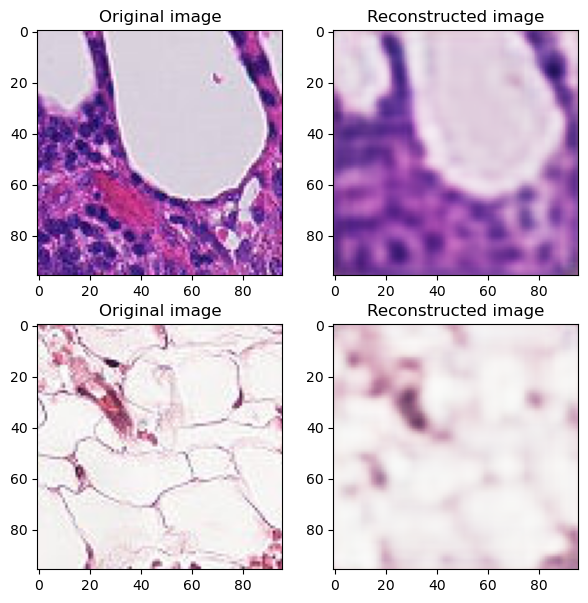

In [109]:
img_batch = train_gen[0][0]
predict_test = AE.predict(img_batch) # [batch][class][image_nr]
image_nr = 1

fig,ax = plt.subplots(2,2,figsize=(7,7))

ax[0,0].imshow(img_batch[image_nr])
ax[0,0].set_title('Original image')
ax[0,1].imshow(predict_test[image_nr])
ax[0,1].set_title('Reconstructed image')
ax[1,0].imshow(img_batch[image_nr+1])
ax[1,0].set_title('Original image')
ax[1,1].imshow(predict_test[image_nr+1])
ax[1,1].set_title('Reconstructed image');


### Inserting output in CNN

In [ ]:
AE_train = AE.predict(train_gen[0][0])
# To be continued